# Лабораторная работа №1 по компьютерному зрению
Напылов Евгений 381806-2

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from copy import deepcopy

In [2]:
image = cv2.imread("./lena.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

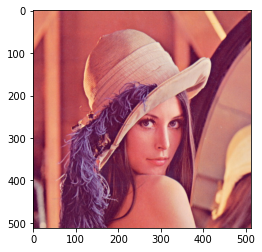

In [3]:
plt.imshow(image)

## 1. Поиск лица

In [4]:
face_cascade = cv2.CascadeClassifier("./haarcascade_frontalface_default.xml")

In [5]:
face_pos = face_cascade.detectMultiScale(image)

In [6]:
f_x = face_pos[0][0]
f_y = face_pos[0][1]
f_w = face_pos[0][2]
f_h = face_pos[0][3]

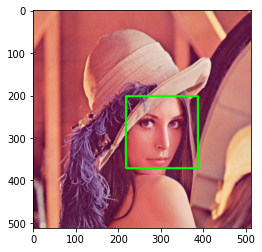

In [7]:
marked_face = cv2.rectangle(deepcopy(image), (f_x, f_y), (f_x + f_w, f_y + f_h), (0, 255, 0), 3)
plt.imshow(marked_face)

## 2. Получение лица с отступами 10%

In [8]:
dx = int(0.1 * f_w)
dy = int(0.1 * f_h)
print(f_x, f_y, f_w, f_h, dx, dy)

218 202 169 169 16 16


In [9]:
face_img = deepcopy(image[f_x-dx:f_x+f_w+dx, f_y-dy:f_y+f_h+dy])

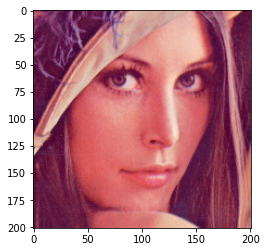

In [10]:
plt.imshow(face_img)

## 3. Получение бинарного изображения краев

In [11]:
edges = cv2.Canny(face_img, 80, 100)

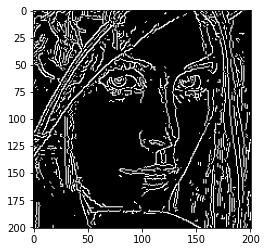

In [12]:
plt.imshow(edges, cmap="gray")

## 4. Удаление мелких границ <10

In [13]:
contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

Для удаления мелких границ нужно найти прямоугольник минимальных размеров, который будет содержать i-ый контур. Из сторон прямоугольника можно судить о размерах контура. Если a>=10 or b>=10, то считаем контур подходящим и рисуем его на новой картинке.

In [14]:
valid_contours = []
for contour in contours:
    rect = cv2.minAreaRect(contour)
    a = rect[1][0]
    b = rect[1][1]
    if a >= 10 or b >= 10: valid_contours.append(contour)

edges.fill(0)
cv2.drawContours(edges, valid_contours, -1, (255, 255, 255), 1)

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0, 255, ...,   0,   0,   0],
       [  0,   0, 255, ...,   0,   0,   0],
       [  0,   0, 255, ...,   0,   0,   0]], dtype=uint8)

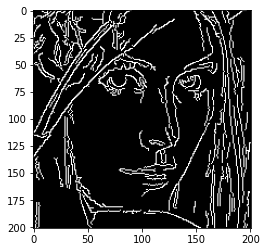

In [15]:
plt.imshow(edges, cmap="gray")

## 5. Морфологическая операция наращивания 5x5

In [16]:
edges = cv2.dilate(edges, kernel=np.ones((5, 5)))

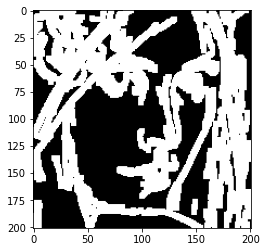

In [17]:
plt.imshow(edges, cmap="gray")

## 6. Гауссовский фильтр 5x5 и нормализация до [0, 1]

In [18]:
edges = cv2.GaussianBlur(edges,(5,5), cv2.BORDER_DEFAULT)

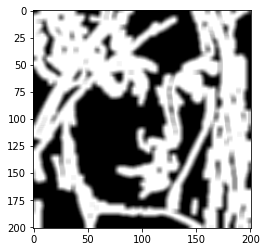

In [19]:
plt.imshow(edges, cmap="gray")

In [20]:
M = cv2.normalize(edges, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

In [21]:
M 

array([[0.        , 0.        , 0.        , ..., 0.6039216 , 0.39607847,
        0.37647063],
       [0.07058824, 0.07450981, 0.1137255 , ..., 0.4901961 , 0.32156864,
        0.30588236],
       [0.26666668, 0.27058825, 0.3137255 , ..., 0.3647059 , 0.2392157 ,
        0.227451  ],
       ...,
       [1.        , 1.        , 1.        , ..., 0.8117648 , 0.79215693,
        0.78823537],
       [1.        , 1.        , 1.        , ..., 0.8117648 , 0.79215693,
        0.78823537],
       [1.        , 1.        , 1.        , ..., 0.8117648 , 0.79215693,
        0.78823537]], dtype=float32)

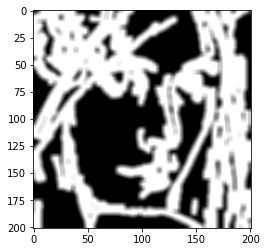

In [22]:
plt.imshow(M, cmap="gray")

## 7. Получение изображения F1 с билатеральной фильтрацией

In [23]:
F1 = cv2.bilateralFilter(face_img, 8, 80, 80)

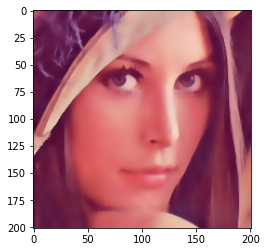

In [24]:
plt.imshow(F1)

## 8. Получение изображения F2 с с улучшенной четкостью/контрастностью.
Использую ядро повышения четкости

In [25]:
kernel = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]])
F2 = cv2.filter2D(face_img, -1, kernel)

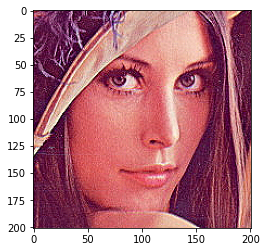

In [26]:
plt.imshow(F2)

## 9. Финальная фильтрация по формуле:
Result[x,y,c] = M[x,y] \* F2[x,y,c] + (1 - M[x,y]) \* F1[x,y,c], где x=1..width, y=1..height, c = 1..3.

In [27]:
Result = deepcopy(face_img)

In [28]:
w = face_img.shape[0]
h = face_img.shape[1]
for x in range(w):
    for y in range(h):
        for c in range(3):
            Result[x][y][c] = M[x][y] * F2[x][y][c] + (1 - M[x][y]) * F1[x][y][c]

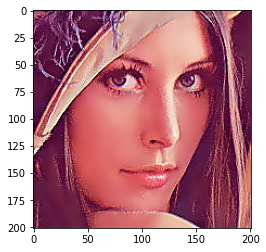

In [29]:
plt.imshow(Result)